In [1]:
from fastai.vision import *

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [2]:
root = Path('../../LIP').resolve()

In [19]:
class RecurrentInstructor(cs.BaseInstructor):
    def __init__(self, repeats):
        self.repeats = repeats
        
    def on_batch_begin(self, **kwargs):
        self.i = 0
    
    def next_inst(self, last_bu):
        self.i += 1
        state = {'continue': self.i < self.repeats}
        return None, state
    
class RecurrentLoss:
    
    def __init__(self, repeats):
        self.r = repeats
        
    def __call__(self, outputs, targets):
        targets = targets.repeat(1, self.r, 1)
#         total_loss = sum(pose.pose_ce_loss(phase_out, targets) for phase_out in outputs[1].split(16, dim=1))
        return pose.pose_ce_loss(outputs[1], targets)
    
       
pckh = partial(pose.Pckh, heatmap_func=lambda last_output: last_output[1][:, -16:])

In [5]:
data = pose.get_data(root, 128)
data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [20]:
instructor = RecurrentInstructor(2)
learner = cs.cs_learner(data, models.resnet18, instructor, td_c=16, pretrained=False, embedding=None,
                        loss_func=RecurrentLoss(2), callback_fns=pckh)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-02
Min loss divided by 10: 2.75E-01


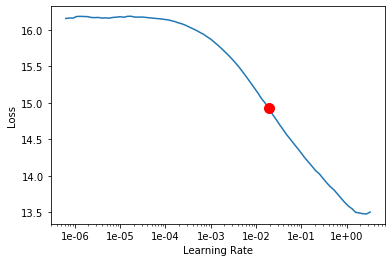

In [11]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
learner.fit_one_cycle(40, 1e-2)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,10.390033,10.038353,0.623686,0.429158,0.249887,0.231800,0.253393,0.237244,0.374306,0.388291,0.347454,04:37
1,9.319100,8.602507,0.723264,0.561116,0.376698,0.303917,0.363959,0.329186,0.403907,0.496221,0.445381,04:16
2,8.798311,8.063608,0.798218,0.630845,0.430555,0.371687,0.410116,0.385682,0.445319,0.562912,0.505005,04:37
3,8.461933,8.302901,0.795642,0.648359,0.453876,0.420115,0.395219,0.397264,0.447897,0.584159,0.517583,03:41
4,8.088418,538759790592.000000,0.798836,0.664653,0.529987,0.476533,0.471231,0.459719,0.474839,0.621338,0.562694,03:30
5,7.892107,6227011614008054441329033216.000000,0.824696,0.684965,0.548817,0.494874,0.504356,0.485719,0.497642,0.642237,0.586279,03:41
6,7.645669,69626793374654743904058867712.000000,0.832784,0.724218,0.584917,0.525864,0.508687,0.527273,0.515474,0.670749,0.611658,03:36
7,7.526010,210833.140625,0.841335,0.717900,0.584587,0.543428,0.498404,0.533776,0.524946,0.675503,0.614852,03:50
8,7.447293,8945909371095339711332352.000000,0.843653,0.746261,0.621611,0.566256,0.538234,0.555153,0.560555,0.697858,0.641137,04:10
9,7.288130,6.771254,0.861632,0.748278,0.631807,0.586542,0.544544,0.572399,0.561430,0.710371,0.652069,04:02


In [16]:
learner.save('repeat2-128')

In [21]:
learner.load('repeat2-128')

Learner(data=ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None, model=CounterStream(
  (bu_body): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padd

In [22]:
learner.data = pose.get_data(root, 256)

In [23]:
learner.fit_one_cycle(40 , 1e-3)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,4.926105,4.395753,0.897589,0.837308,0.740839,0.692453,0.564051,0.567554,0.521076,0.794624,0.702020,09:23
1,4.649168,4.211531,0.905986,0.850052,0.764899,0.722162,0.592745,0.618238,0.571703,0.813066,0.729507,07:55
2,4.518838,4.140831,0.910674,0.856839,0.778697,0.740333,0.616804,0.656937,0.606793,0.823749,0.748341,08:56
3,4.423072,4.043563,0.915516,0.863629,0.789993,0.752757,0.635457,0.684560,0.647863,0.832483,0.764410,09:04
4,4.338748,3.985364,0.919843,0.868587,0.798230,0.764237,0.650954,0.706227,0.683412,0.839641,0.777688,08:53
5,4.274280,3.950999,0.921904,0.871511,0.805345,0.769022,0.662181,0.719391,0.701801,0.843821,0.785583,09:25
6,4.228867,3.909516,0.924222,0.876472,0.811345,0.776067,0.673491,0.732366,0.715570,0.848842,0.793485,08:25
7,4.181600,3.907747,0.923862,0.877461,0.810433,0.778338,0.675236,0.737341,0.722566,0.849323,0.795420,08:52
8,4.162936,3.964754,0.921337,0.873546,0.803343,0.771275,0.664253,0.727458,0.720801,0.844248,0.789205,07:15
9,4.137141,3.895944,0.925613,0.880434,0.817741,0.783659,0.678999,0.741137,0.736731,0.853596,0.800614,09:14


In [24]:
learner.save('repeat2-256')

In [18]:
%debug

> /home/labs/waic/omrik/csPose/pose.py(162)pose_ce_loss()
    160     is_visible = targets[..., 2] > 0
    161     gt = targets[..., :2][is_visible]
--> 162     output = output[is_visible]
    163     return ce_loss(output, gt)
    164 

ipdb> output.shape
*** AttributeError: 'tuple' object has no attribute 'shape'
ipdb> q
